In [1]:
# imports 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms.functional as TF


(512, 512)
0.003921569 0.9882353
float32


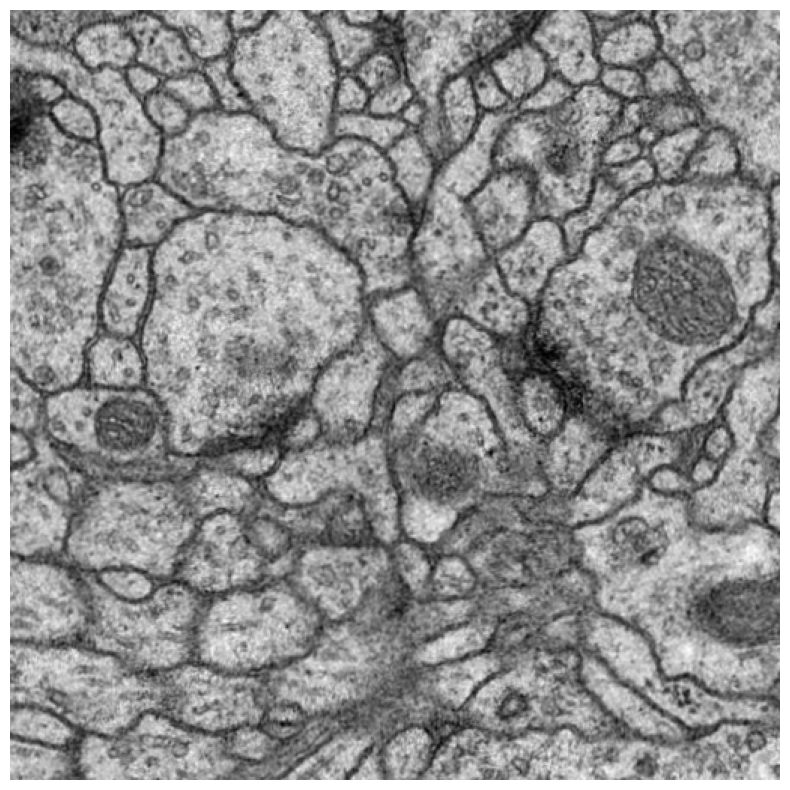

In [2]:
folder = 'data/train_images/'

# read train_images
def read_train_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        # normalize the image to [0, 1]
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return images

images = read_train_images(folder)

# show the first image
print(images[0].shape)
print(images[0].min(),images[0].max())
print(images[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(images[0], cmap = 'gray')
plt.axis('off')
plt.show()

(512, 512)
0.0 1.0
float32


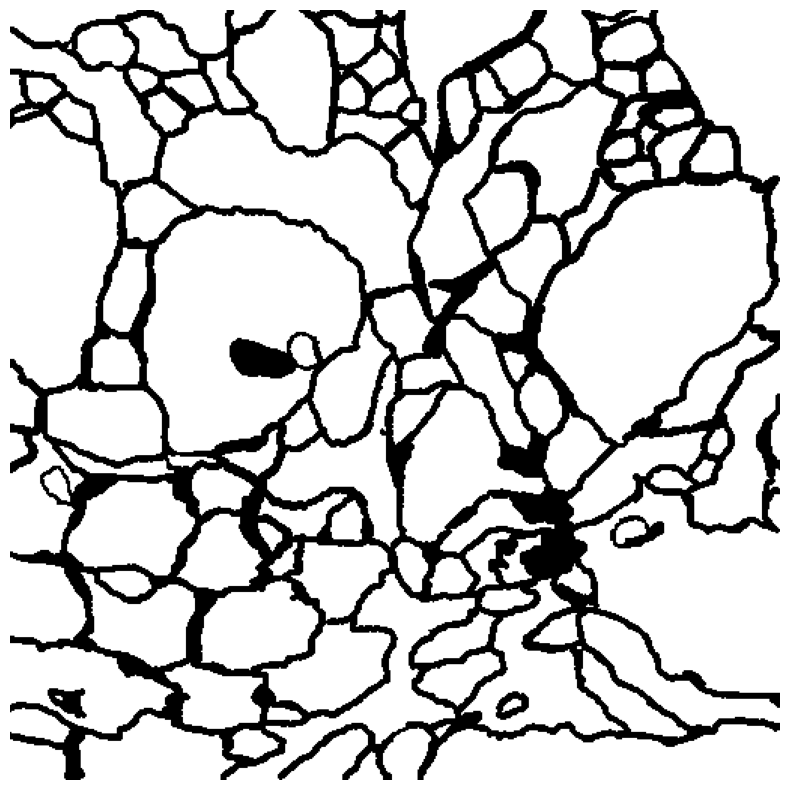

In [3]:
folder = 'data/train_labels/'

labels = read_train_images(folder)

# show the first image
print(labels[0].shape)
print(labels[0].min(),labels[0].max())
print(labels[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap = 'gray')
plt.axis('off')
plt.show()

In [4]:
# do patches of the images, of 128x128
def create_patches(images, patch_size=256):
    patches = []
    for image in images:
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patches.append(patch)
    
    return patches

# create patches of the first image
patches_images = create_patches(images, patch_size=256)

patches_images_ex = patches_images[16*10:16*11]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_images_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [5]:
# create patches of the first image
patches_labels = create_patches(labels, patch_size=256)

patches_labels_ex = patches_labels[16*10:16*11]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_labels_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [6]:
# test set
folder = 'data/test_images/'
# read test_images
test_images = read_train_images(folder)
patches_test_images = create_patches(test_images, patch_size=256)


In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # grayscale: in_channels=1
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Final output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out_conv(d1))  # for binary segmentation

'''
# Example
model = UNet(in_channels=1, out_channels=1)
#x = torch.randn(1, 1, 128, 128)  # grayscale image
x = patches_images[0]  # use the first patch
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
y = model(x)
print(y.shape)  # should be [1, 1, 128, 128]
'''

'\n# Example\nmodel = UNet(in_channels=1, out_channels=1)\n#x = torch.randn(1, 1, 128, 128)  # grayscale image\nx = patches_images[0]  # use the first patch\nx = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions\ny = model(x)\nprint(y.shape)  # should be [1, 1, 128, 128]\n'

In [8]:
class JointTransform:
    def __init__(self, hflip=True, vflip=True, rotation=True):
        self.hflip = hflip
        self.vflip = vflip
        self.rotation = rotation

    def __call__(self, image, label):
       
        image = TF.hflip(image)
        label = TF.hflip(label)
    
        image = TF.vflip(image)
        label = TF.vflip(label)

        angles = [0, 90, 180, 270]
        angle = random.choice(angles)
        image = TF.rotate(image, angle)
        label = TF.rotate(label, angle)

        return image, label

In [9]:
class PatchDataset(Dataset):
    def __init__(self, image_patches, label_patches=None, transform=None):
        self.image_patches = image_patches
        self.label_patches = label_patches
        self.transform = transform

    def __len__(self):
        return len(self.image_patches)

    def __getitem__(self, idx):
        image = self.image_patches[idx]

        if self.transform:
            image = self.transform(image)

        if self.label_patches is not None:
            label = self.label_patches[idx]
            return image, label
        else:
            return image


In [10]:
# maybe convert your patches to tensors first if they are still numpy arrays
image_patches = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_images]
label_patches = [torch.tensor(lbl, dtype=torch.float32).unsqueeze(0) for lbl in patches_labels]
image_patches_test = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_test_images]
print(len(image_patches), len(label_patches), len(image_patches_test))
transform = JointTransform()

augmented_images = []
augmented_labels = []

# Apply 3 augmentations per original image
for img, lbl in zip(image_patches, label_patches):
    for _ in range(2):
        img_aug, lbl_aug = transform(img, lbl)
        augmented_images.append(img_aug)
        augmented_labels.append(lbl_aug)

# Combine original and augmented
all_images = image_patches + augmented_images
all_labels = label_patches + augmented_labels

print(len(all_images), len(all_labels))

120 120 120
360 360


In [67]:
# Get a test set with only 5% of the data
X_temp, X_test, y_temp, y_test = train_test_split(all_images, all_labels, test_size=0.05, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Create datasets
train_dataset = PatchDataset(X_train, y_train)
val_dataset = PatchDataset(X_val, y_val)
mini_test_dataset = PatchDataset(X_test, y_test)
test_set = PatchDataset(image_patches_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
mini_test_loader = DataLoader(mini_test_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# Check the length of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Mini test dataset size: {len(mini_test_dataset)}")
print(f"Test dataset size: {len(test_set)}")

Train dataset size: 256
Validation dataset size: 86
Mini test dataset size: 18
Test dataset size: 120


In [12]:
# Define model
model = UNet(in_channels=1, out_channels=1)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Define loss and opti
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

Using device: cuda


In [98]:
# Metrics
def dice_coeff(pred, target, threshold=0.5, epsilon=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

def iou_coeff(pred, target, threshold=0.5, epsilon=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean().item()

def compute_sensitivity(outputs, labels):
    preds_bin = (outputs > 0.5)
    labels_bin = (labels == 1)  # or labels.bool(), if labels are already binary

    # True Positives: prediction is 1 and label is 1
    tp = (preds_bin & labels_bin).sum().item()

    # False Negatives: prediction is 0 but label is 1
    fn = ((~preds_bin) & labels_bin).sum().item()

    # Sensitivity = TP / (TP + FN)
    sensitivity_score = tp / (tp + fn + 1e-8)  # epsilon to avoid zero division

    return sensitivity_score

In [14]:
# Create a train one epoch function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0
    total_iou = 0
    sensitivity_score = 0
    num_batches = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Pixel accuracy
        preds_bin = outputs > 0.5
        correct_pixels += (preds_bin == labels.bool()).sum().item()
        total_pixels += torch.numel(labels)

        # Dice & IoU
        total_dice += dice_coeff(outputs, labels)
        total_iou += iou_coeff(outputs, labels)

        # Sensitivity
        sensitivity_score += compute_sensitivity(outputs, labels)

        num_batches += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    sensitivity = sensitivity_score / num_batches

    return epoch_loss, pixel_acc, avg_dice, avg_iou, sensitivity

In [15]:
# create a validate one epoch function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0
    total_iou = 0
    sensitivity_score = 0
    num_batches = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            # Pixel accuracy
            preds_bin = outputs > 0.5
            correct_pixels += (preds_bin == labels.bool()).sum().item()
            total_pixels += torch.numel(labels)

            # Dice & IoU
            total_dice += dice_coeff(outputs, labels)
            total_iou += iou_coeff(outputs, labels)

            # Sensitivity
            sensitivity_score += compute_sensitivity(outputs, labels)

            num_batches += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    sensitivity = sensitivity_score / num_batches
    
    return epoch_loss, pixel_acc, avg_dice, avg_iou, sensitivity

In [16]:
# Make training and val loop
num_epochs = 20
train_accs = []
train_dices = []
train_ious = []
train_sensitivities = []

val_accs = []
val_dices = []
val_ious = []
val_sensitivities = []

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou, train_sensitivity = train_one_epoch(model, train_loader, criterion=loss_fn, optimizer=optimizer, device=device)
    val_loss, val_acc, val_dice, val_iou, val_sensitivity = validate(model, val_loader, criterion=loss_fn, device=device)

    train_accs.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)
    train_sensitivities.append(train_sensitivity)

    val_accs.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)
    val_sensitivities.append(val_sensitivity)

    print(f"Epoch {epoch+1}/{num_epochs}:\nTrain acc: {train_acc:.4f}\nTrain loss: {train_loss:.4f}\nVal acc: {val_acc:.4f}\nVal loss: {val_loss:.4f}")
    print(f"Sensitivity: {train_sensitivity:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"Val Sensitivity: {val_sensitivity:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")
    print("-" * 50)

Epoch 1/20:
Train acc: 0.7636
Train loss: 1.6638
Val acc: 0.8166
Val loss: 0.3519
Sensitivity: 0.9422 | Dice: 0.8447 | IoU: 0.7507
Val Sensitivity: 0.9377 | Val Dice: 0.8877 | Val IoU: 0.7993
--------------------------------------------------
Epoch 2/20:
Train acc: 0.8251
Train loss: 0.3498
Val acc: 0.8332
Val loss: 0.3329
Sensitivity: 0.8826 | Dice: 0.8853 | IoU: 0.7962
Val Sensitivity: 0.8739 | Val Dice: 0.8888 | Val IoU: 0.8019
--------------------------------------------------
Epoch 3/20:
Train acc: 0.8351
Train loss: 0.3363
Val acc: 0.8418
Val loss: 0.3242
Sensitivity: 0.8979 | Dice: 0.8934 | IoU: 0.8087
Val Sensitivity: 0.9268 | Val Dice: 0.9004 | Val IoU: 0.8203
--------------------------------------------------
Epoch 4/20:
Train acc: 0.8471
Train loss: 0.3203
Val acc: 0.8511
Val loss: 0.3113
Sensitivity: 0.9203 | Dice: 0.9029 | IoU: 0.8241
Val Sensitivity: 0.8906 | Val Dice: 0.9018 | Val IoU: 0.8225
--------------------------------------------------
Epoch 5/20:
Train acc: 0.852

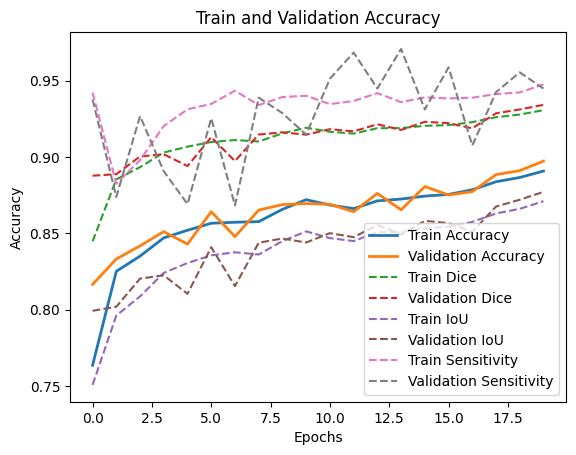

In [17]:
# plot the train and val loss
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.plot(train_dices, label='Train Dice', linestyle='--')
plt.plot(val_dices, label='Validation Dice', linestyle='--')
plt.plot(train_ious, label='Train IoU', linestyle='--')
plt.plot(val_ious, label='Validation IoU', linestyle='--')
plt.plot(train_sensitivities, label='Train Sensitivity', linestyle='--')
plt.plot(val_sensitivities, label='Validation Sensitivity', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the model
#torch.save(model.state_dict(), './models/big_unet/model_epochs20_batch8_patch256_lr1e-3_aug2_SENSITIVITY.pth')

In [13]:
# load model weights
model.load_state_dict(torch.load('./models/big_unet/model_epochs20_batch8_patch256_lr1e-3_aug2_SENSITIVITY.pth'))

<All keys matched successfully>

In [14]:
# Predict with test
def predict(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs.cpu())

    return torch.cat(predictions, dim=0)

In [23]:
# Predict on test set
predictions = predict(model, test_loader, device=device)
print(predictions.shape)  # should be [num_test_images, 1, 256, 256]
# Convert predictions to numpy
predictions_np = predictions.numpy()

torch.Size([120, 1, 256, 256])


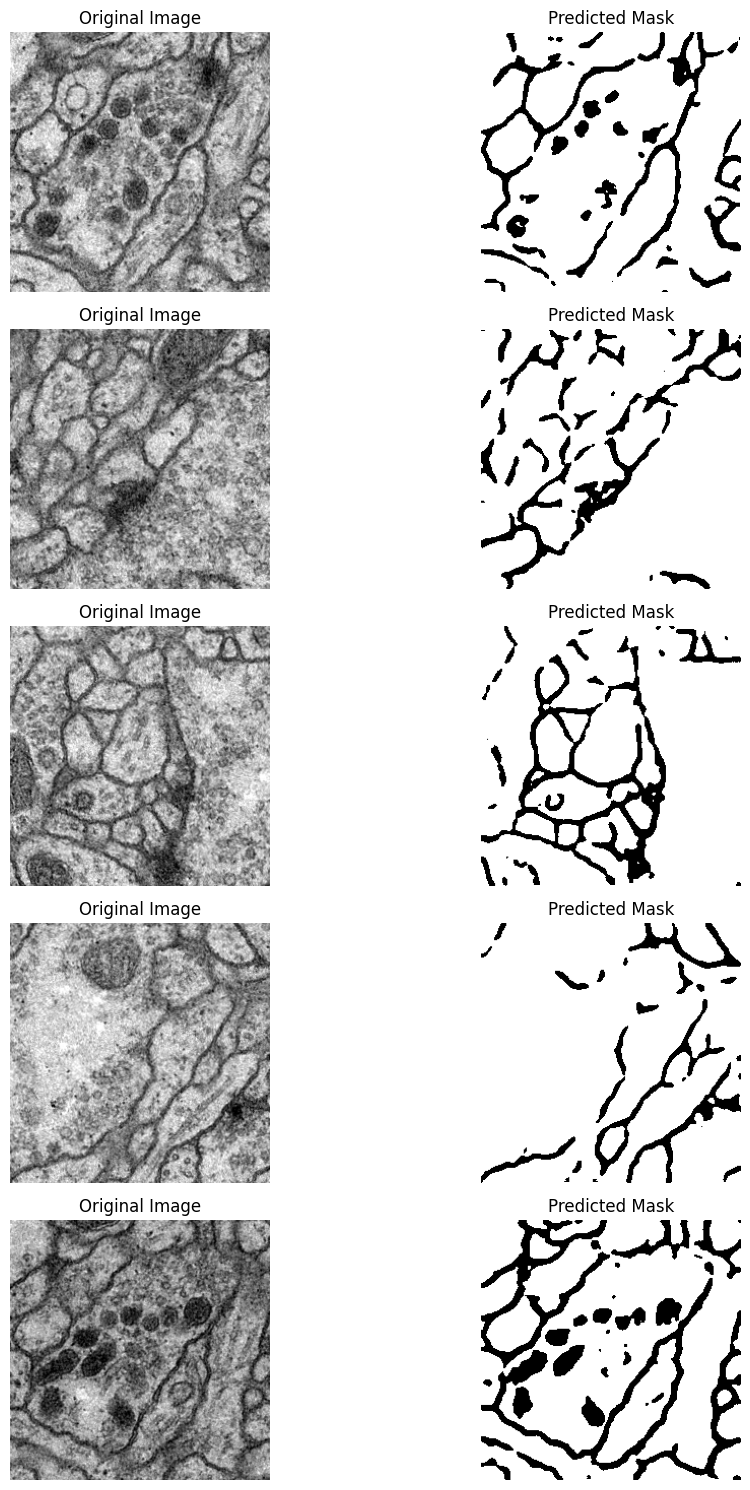

In [24]:
# Plot some predictions with their ground truth and original images
def plot_predictions(original_images, predictions, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow((predictions[i]>=0.5).squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# Plot some predictions
plot_predictions(patches_test_images[:5], predictions_np[:5], num_images=5)

In [ ]:
# Predict with test
def predict_mini_test(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs.cpu())

    return torch.cat(predictions, dim=0)

In [37]:
# Predict with test set images
predictions_mini_test = predict_mini_test(model, mini_test_loader, device=device)
print(predictions_mini_test.shape)  # should be [num_test_images, 1, 256, 256]
# Convert predictions to numpy
predictions_mini_test_np = predictions_mini_test.numpy()

torch.Size([18, 1, 256, 256])


In [72]:
# Plot mini test predictions with their ground truth and original images
def plot_mini_test_predictions(original_images, labels, predictions, num_images=5):
    plt.figure(figsize=(30, 30))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow((predictions[i]>=0.5).squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

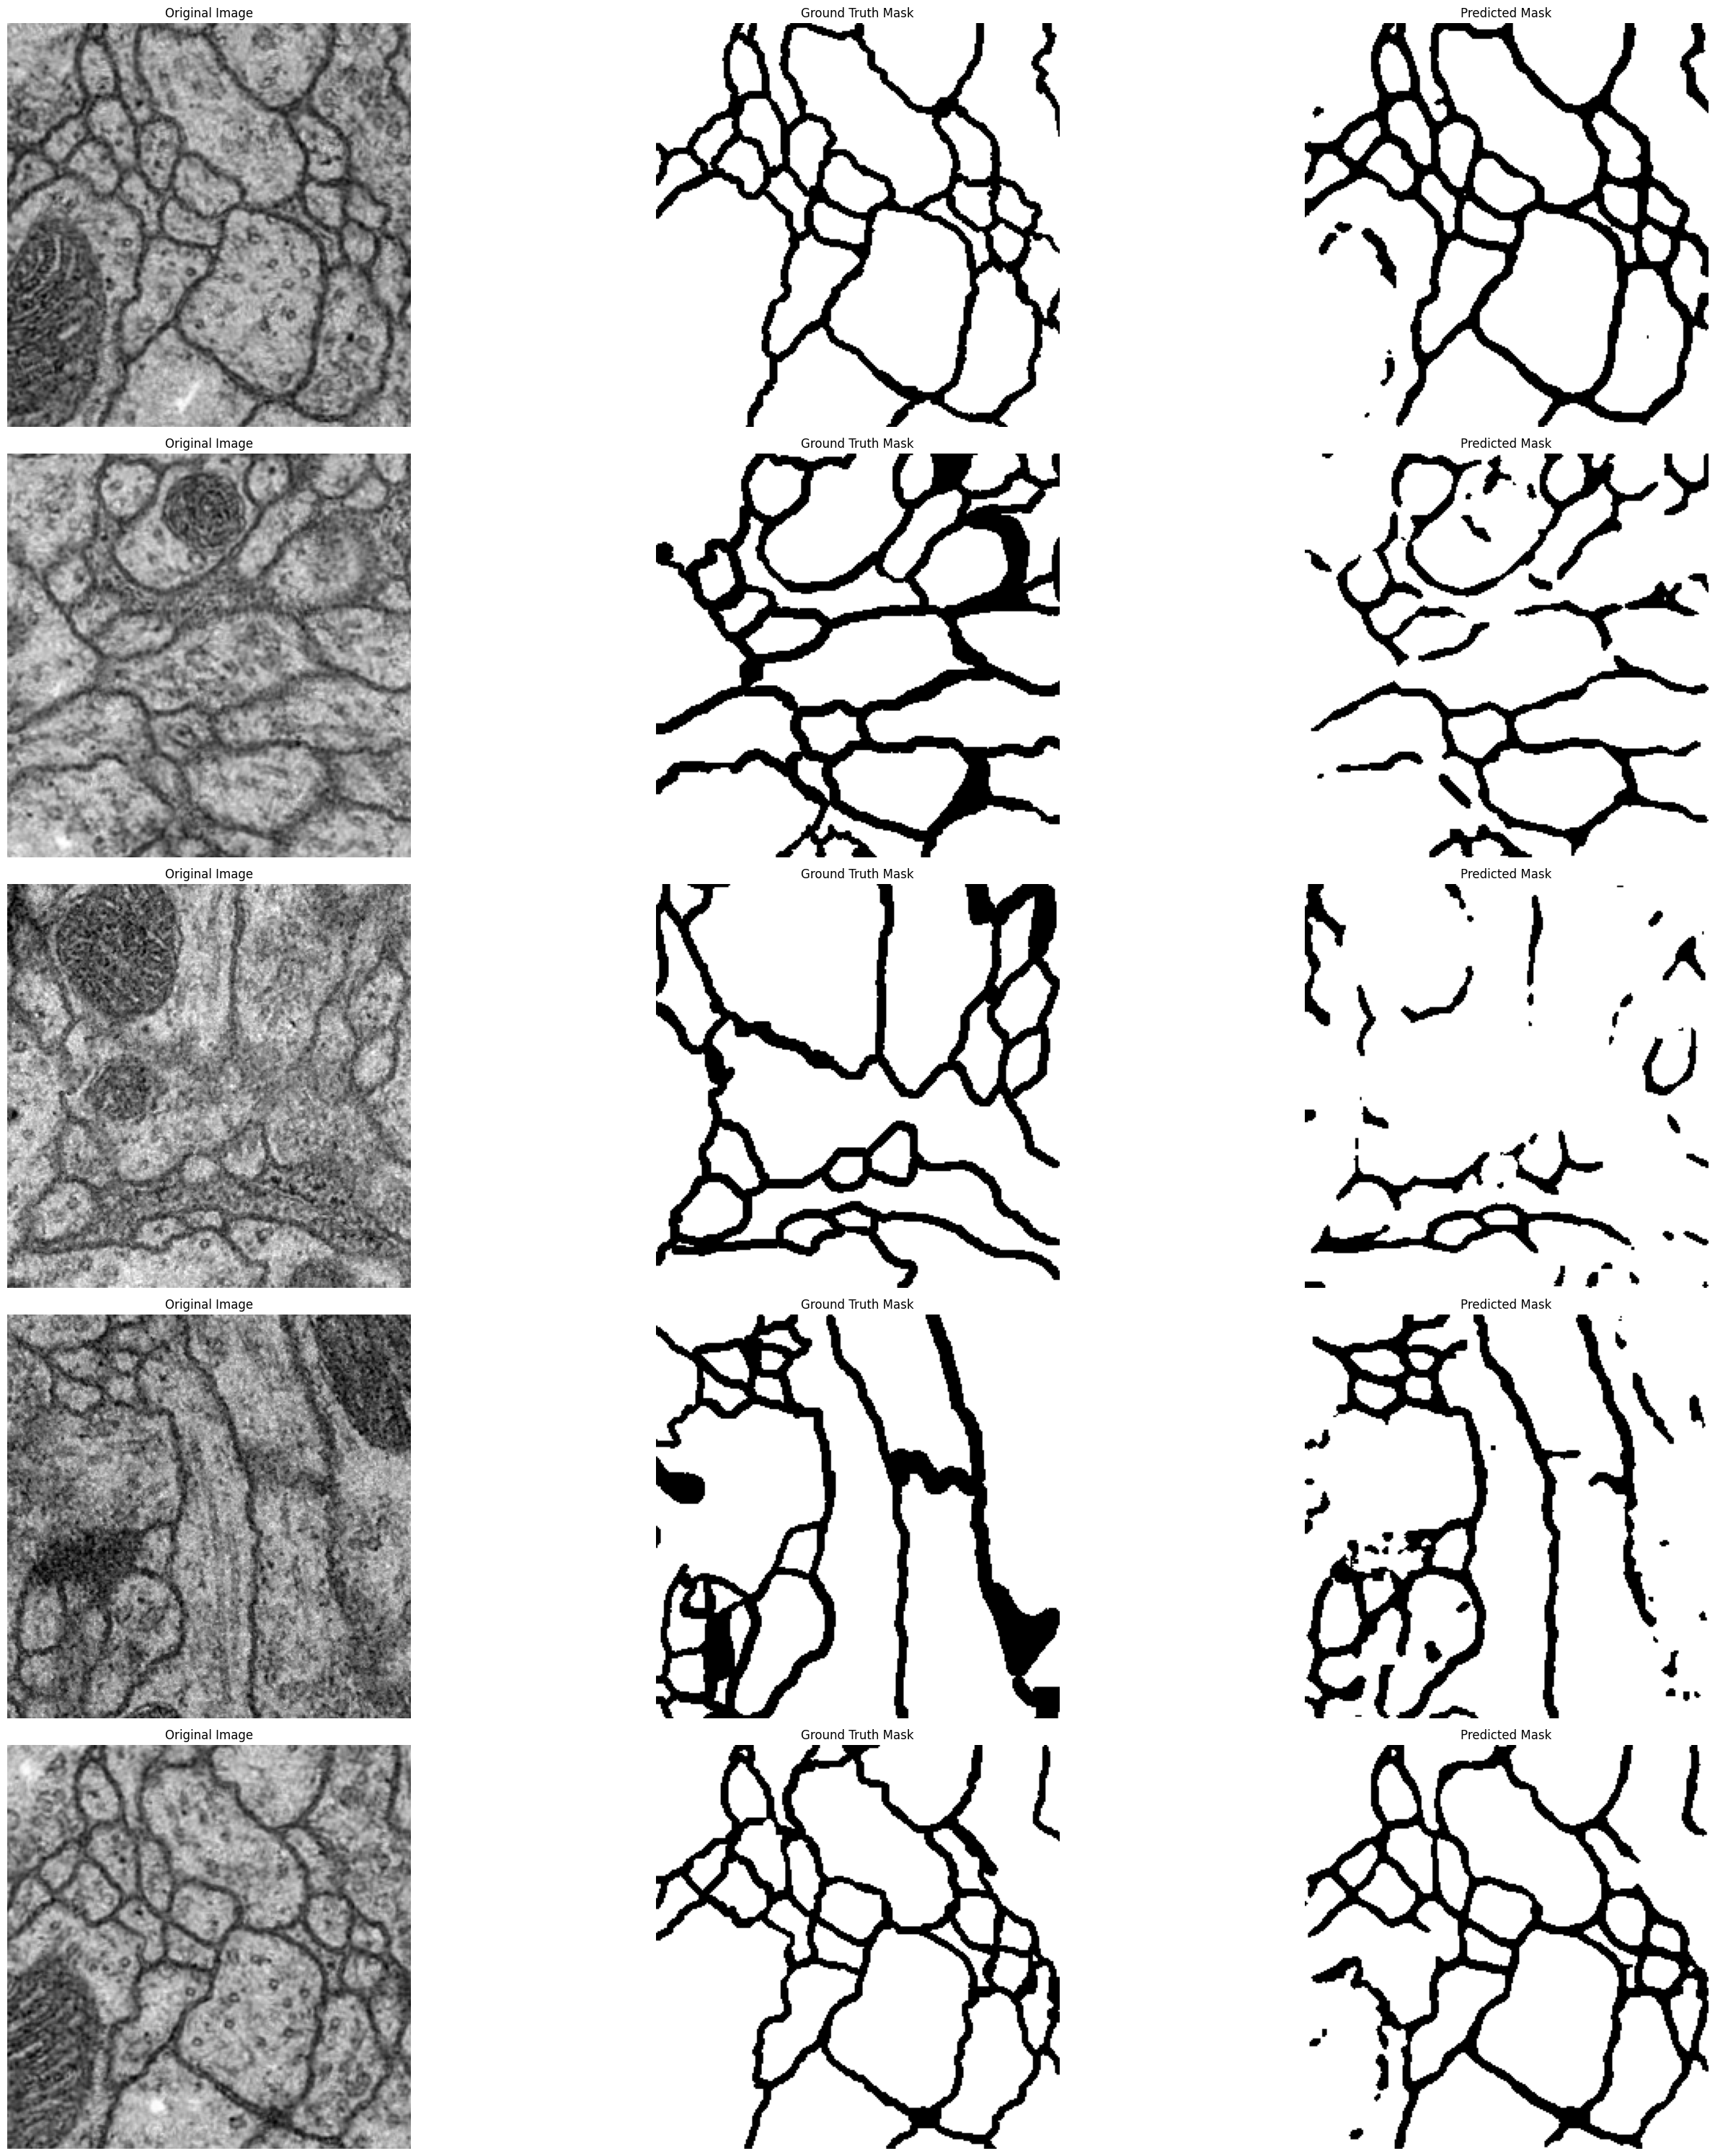

In [75]:
mini_test_images = []
mini_test_labels = []

for images, labels in mini_test_dataset:
    mini_test_images.append(images)
    mini_test_labels.append(labels)

plot_mini_test_predictions(mini_test_images, mini_test_labels, predictions_mini_test_np, num_images=5)

Total difference in pixels is:  tensor(3682.)


/tmp/ipykernel_5101/4175437890.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = np.abs(gt - (preds >= 0.5))


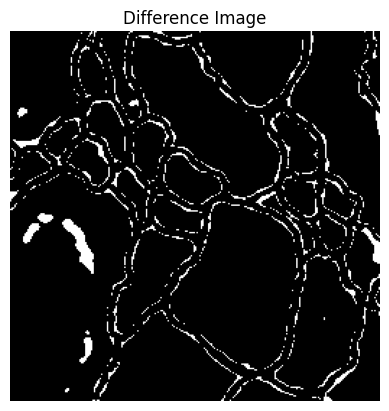

Total difference in pixels is:  tensor(7930.)


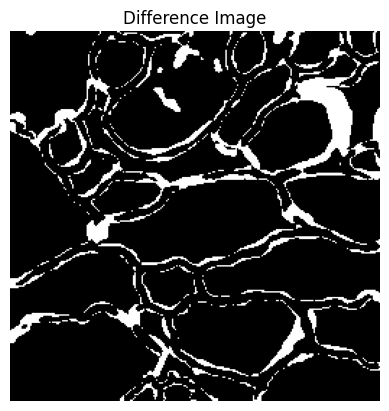

Total difference in pixels is:  tensor(9770.)


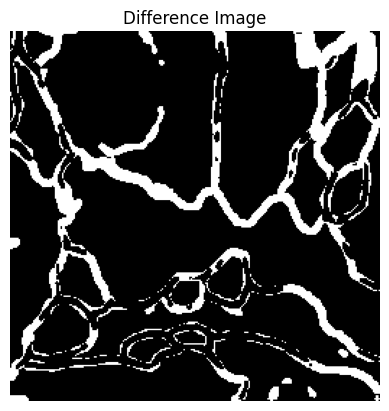

Total difference in pixels is:  tensor(8399.)


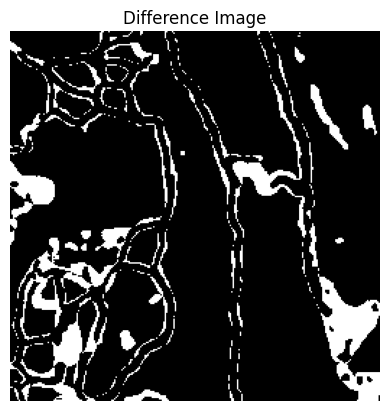

Total difference in pixels is:  tensor(4109.)


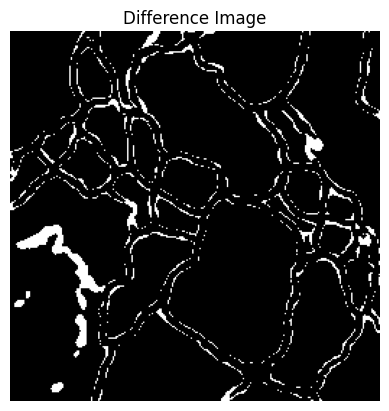

In [84]:
i = 1
for gt, preds in zip(mini_test_labels, predictions_mini_test_np):
    diff = np.abs(gt - (preds >= 0.5))
    print("Total difference in pixels is: ", diff.sum())

    plt.imshow(diff.squeeze(), cmap='gray')
    plt.title('Difference Image')
    plt.axis('off')
    plt.show()

    i += 1
    
    if i > 5:
        break

In [107]:
dice_coeffs = []
iou_coeffs = []
s = []

for i, (image, label, pred) in enumerate(zip(mini_test_images, mini_test_labels, predictions_mini_test_np), 1):
    # Ensure they are torch tensors with shape (1, 1, H, W)
    pred_tensor = torch.tensor(pred).unsqueeze(0).unsqueeze(0).float()
    label_tensor = torch.tensor(label).unsqueeze(0).unsqueeze(0).float()

    # Calculate metrics
    dice = dice_coeff(pred_tensor, label_tensor)
    iou = iou_coeff(pred_tensor, label_tensor)
    sensitivity = compute_sensitivity(pred_tensor, label_tensor)

    dice_coeffs.append(dice)
    iou_coeffs.append(iou)
    s.append(sensitivity)


# Create df
df = pd.DataFrame({
    'Image': [i for i in range(1, len(mini_test_images) + 1)],
    'Dice': dice_coeffs,
    'IoU': iou_coeffs,
    'Sensitivity': s
})

df

/tmp/ipykernel_5101/3139704190.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label).unsqueeze(0).unsqueeze(0).float()


Image      Dice       IoU  Sensitivity
0       1  0.964194  0.931782     0.945553
1       2  0.921320  0.856441     0.976021
2       3  0.908494  0.837212     0.975549
3       4  0.916233  0.849557     0.941868
4       5  0.959889  0.924311     0.954343
5       6  0.948165  0.903371     0.966396
6       7  0.913800  0.844855     0.931206
7       8  0.934447  0.878949     0.945401
8       9  0.955000  0.915148     0.954938
9      10  0.919306  0.853311     0.943767
10     11  0.909907  0.837652     0.971423
11     12  0.957995  0.920451     0.944464
12     13  0.888333  0.804457     0.889291
13     14  0.942661  0.895627     0.959695
14     15  0.918071  0.850588     0.921212
15     16  0.903321  0.827951     0.929160
16     17  0.917082  0.850808     0.936578
17     18  0.941121  0.890180     0.941557